# LES Band Orientation Model
---
Central Lake Ontario Buoy Environmental Database Model

### Carter J. Humphreys
Email: [chumphre@oswego.edu](mailto:chumphre@oswego.edu) | GitHub:[@HumphreysCarter](https://github.com/HumphreysCarter) | Website: [carterhumphreys.com](http://carterhumphreys.com/)

In [1]:
import random

import pyart
import math
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from os import walk
from metpy.plots import USCOUNTIES, colortables
from metpy.io import Level2File
from datetime import datetime, timedelta


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
def find_nthIndex(fullString, find, n):
    start = fullString.find(find)
    while start >= 0 and n > 1:
        start = fullString.find(find, start+len(find))
        n -= 1
    return start

# Rounds to nearest hour by adding a timedelta hour if minute >= 30
def roundTimeToNearestHour(t):
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)+timedelta(hours=t.minute//30))

## Load Model

In [3]:
model=joblib.load('models/LES_Band_Position_Model_KNN(n=2)_LO1_LatLon')

## Load Dataset

In [4]:
# Load data from CSV
dataPath="data/LO1_dataset.csv"
dataset=pd.read_csv(dataPath)
print(dataset.shape)

# Extract time, position, and enviorment data
timeData=dataset.values[:,0:1]
enviormentData=dataset.values[:,10:40]
print(enviormentData)

(1145, 40)
[[13.26 0.0 0.0 ... 37.65 -12.4 26.86]
 [13.26 0.0 0.0 ... 36.14 -13.87 30.15]
 [13.26 0.0 0.0 ... 34.44 -13.16 28.75]
 ...
 [2.23 4.63 19.43 ... 30.79 9.28 22.16]
 [2.23 4.63 19.43 ... 32.32 5.9 25.14]
 [2.23 4.63 19.43 ... 33.84 1.33 32.51]]


## Make Prediction

In [5]:
i=random.randint(0, len(enviormentData)-1)
inputData=enviormentData[i]

prediction=model.predict([inputData])[0]
print(f'{prediction}')

[ 43.926199   -76.283062    44.18282784 -75.22784203  44.4486485
 -74.1856005 ]


## Visualize Prediction

In [6]:
# Radar Plot Settings
product='reflectivity'
cmap=colortables.get_colortable('Carbone42')
dataMin=-23
dataMax=77
units='dBZ'
showLatLon=True
showCountryBorders=True
showStateBorders=True
showCountyBorders=True

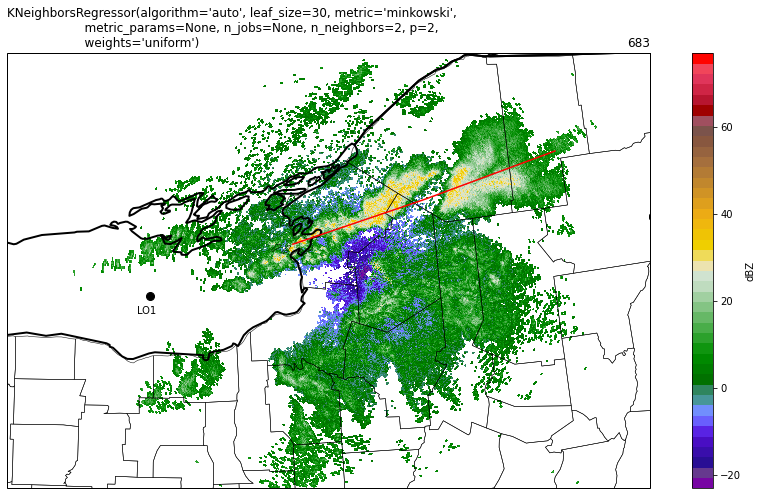

In [7]:
# Find radar data for time
postionTime=datetime.strptime(timeData[i][0], '%Y-%m-%d %H:%M:%S')

radarDir='data/NEXRAD/'
radarFile=''
for (dirpath, dirnames, filenames) in walk(radarDir):
    for file in filenames:
        time=file[find_nthIndex(file, '-', 1)+5:find_nthIndex(file, '_', 4)]
        time=datetime.strptime(time, '%Y%m%d_%H%M%S')
        time=roundTimeToNearestHour(time)

        if time==postionTime:
            dir=file[:find_nthIndex(file, '-', 1)]
            radarFile=f'/{dir}/{file}'
            break
            
# Read in data
radar = pyart.io.read_nexrad_archive(radarDir+radarFile)
display = pyart.graph.RadarMapDisplay(radar)
site=radar.metadata['instrument_name']
time=datetime.strptime(radar.time['units'], 'seconds since %Y-%m-%dT%H:%M:%SZ')
sweep=0
if product=='velocity':
    sweep=1

# Setup projection
plotExtent = [-78.5, -73.5, 42.5, 45]

proj = ccrs.LambertConformal(central_longitude=((plotExtent[1]-plotExtent[0])/2+plotExtent[0]), central_latitude=((plotExtent[3]-plotExtent[2])/2+plotExtent[2]))
lon_lines=np.arange(round(plotExtent[0]-1, 0), round(plotExtent[1]+1, 0), 0.5)
lat_lines=np.arange(round(plotExtent[2]-1, 0), round(plotExtent[3]+1, 0), 0.5)

# Setup plot
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Make plot
display.plot_ppi_map(product, sweep, vmin=dataMin, vmax=dataMax, cmap=cmap, title=' ', colorbar_label=units,
                    min_lon=plotExtent[0], max_lon=plotExtent[1], min_lat=plotExtent[2], max_lat=plotExtent[3],
                    ax=ax, raster=True, embelish=False)

# Add geographic features
state_borders=cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='10m', facecolor='none')
ax.add_feature(state_borders, edgecolor='black', linewidth=2.0)
ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor='black', linewidth=0.5)

# Plot LO1
LO1_lat=43.62
LO1_lon=-77.41
display.plot_point(LO1_lon, LO1_lat, label_text='LO1', label_offset=[-0.10,-0.10], symbol='o', markersize=8, color='k')

# Plot band prediction
display.plot_line_geo([prediction[1], prediction[3], prediction[5]], [prediction[0], prediction[2], prediction[4]])

# Show Plot
plt.title(model, loc='left')
plt.title(i, loc='right')
plt.show()